In [124]:
import pandas as pd
import numpy as np
import nltk

#viz y plots bonitos
import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 16, 8

#ML
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.metrics import (explained_variance_score, roc_auc_score,
                            classification_report, confusion_matrix,
                            roc_curve, accuracy_score)

from sklearn.ensemble import GradientBoostingClassifier
import scikitplot as skp

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

%matplotlib inline

In [125]:
data = open('text_classfier.txt').read()
etiquetas, texto = [], []
for i, line in enumerate(data.split("\n")):
    if i>0:
        content = line.split()
        etiquetas.append(content[0])
        texto.append(" ".join(content[1:]))

# create a dataframe using texts and lables
df = pd.DataFrame()
df['texto'] = texto
df['etiqueta'] = etiquetas

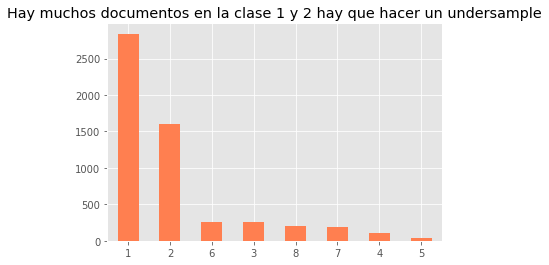

In [126]:
df.etiqueta.value_counts().plot.bar(rot = 0, color='coral', title='Hay muchos documentos en la clase 1 y 2 hay que hacer un undersample')

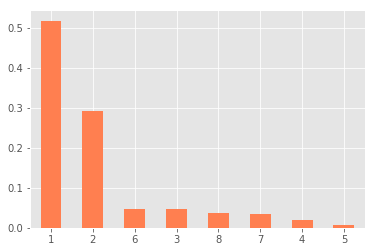

In [18]:
# en porcentaje hay casi 50% de clase 1
df.etiqueta.value_counts(normalize=True).plot.bar(rot = 0, color='coral')

In [72]:
df.etiqueta.value_counts(normalize=True).values

array([0.51777575, 0.29097539, 0.0461258 , 0.04576117, 0.03755697,
       0.03463993, 0.01969006, 0.00747493])

# Preprocesamiento de datos

In [50]:
# revisar si todas estan en minusculas
len([j for i in df.texto for j in i if j.isupper()])
#no tiene mayusculas

0

In [44]:
# revisar si tiene stopwords
from nltk.corpus import stopwords
sw = set(stopwords.words('english'))

In [47]:
#no tiene stopwords
print(len([i for i in df.texto]))
print(len([i for i in df.texto if i not in sw]))

5485
5485


In [51]:
#Se parte el DF en train, test, valid (80%, 10%, 10%) con semilla 8\
rs = check_random_state(8)
Xtrain, Xtest_valid, Ytrain, Ytest_valid = train_test_split(
    df.texto,
    df.etiqueta,
    test_size=0.20,
    random_state=rs)

Xtest, Xvalid, Ytest, Yvalid = train_test_split(
    Xtest_valid, Ytest_valid, test_size=0.50, random_state=rs)

In [52]:
# vectorizando palabras 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df['texto'])

# transformacion a vecotres
xtrain_count =  count_vect.transform(Xtrain)
xtest_count =  count_vect.transform(Xtest)
xvalid_count =  count_vect.transform(Xvalid)

In [116]:
#Tamaño grid depth
ND = 5
min_depth = 8
max_depth =12
grid_depth =  np.linspace(min_depth,max_depth,ND).astype('int')
# tamaño grid ntrees
NT = 2
min_trees = 300
max_trees = 500
grid_tree = np.linspace(min_trees, max_trees, NT).astype('int')

acc_error = np.zeros((ND,NT))

for i, max_depth in enumerate(grid_depth):
    for j,ntrees in enumerate(grid_tree):
        clf = GradientBoostingClassifier(n_estimators= ntrees, max_depth = max_depth,
                                                  subsample=0.8, max_features='sqrt')

# hacer unestimación sobre train
        clf.fit(xtrain_count, Ytrain)
    # hagamos un predict: tst
        acc_test = accuracy_score(Ytest, clf.predict(xtest_count))
    # y guardemos
        acc_error[i,j] = acc_test
        print("iteracion:",j+1,"numero de arboles:", ntrees,"profundidad maxima:", max_depth,"error:", acc_test)

iteracion: 1 numero de arboles: 300 profundidad maxima: 8 error: 0.9562043795620438
iteracion: 2 numero de arboles: 500 profundidad maxima: 8 error: 0.958029197080292
iteracion: 1 numero de arboles: 300 profundidad maxima: 9 error: 0.9562043795620438
iteracion: 2 numero de arboles: 500 profundidad maxima: 9 error: 0.958029197080292
iteracion: 1 numero de arboles: 300 profundidad maxima: 10 error: 0.9470802919708029
iteracion: 2 numero de arboles: 500 profundidad maxima: 10 error: 0.9635036496350365
iteracion: 1 numero de arboles: 300 profundidad maxima: 11 error: 0.9525547445255474
iteracion: 2 numero de arboles: 500 profundidad maxima: 11 error: 0.958029197080292
iteracion: 1 numero de arboles: 300 profundidad maxima: 12 error: 0.9525547445255474
iteracion: 2 numero de arboles: 500 profundidad maxima: 12 error: 0.9635036496350365


In [119]:
clf = GradientBoostingClassifier(max_depth=12, n_estimators=500, 
          subsample=0.8, max_features='sqrt')
# hacer unestimación sobre train
clf.fit(xtrain_count, Ytrain)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=12,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [120]:
#se hace una prediccion para el conjunto de validacion
yhat_valid = clf.predict(xvalid_count)

In [121]:
print(classification_report(Yvalid, yhat_valid))

              precision    recall  f1-score   support

           1       0.99      0.97      0.98       268
           2       0.91      0.98      0.95       175
           3       0.94      0.94      0.94        35
           4       1.00      0.86      0.92         7
           5       0.00      0.00      0.00         3
           6       0.95      0.95      0.95        22
           7       0.86      0.80      0.83        15
           8       0.90      0.75      0.82        24

   micro avg       0.95      0.95      0.95       549
   macro avg       0.82      0.78      0.80       549
weighted avg       0.95      0.95      0.95       549



/home/serch/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


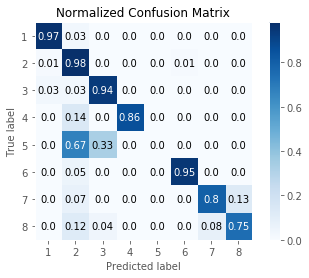

In [122]:
skp.metrics.plot_confusion_matrix(Yvalid, yhat_valid, normalize=True)

In [123]:
print('Acuracy: %1.3f' % accuracy_score(Yvalid, yhat_valid))

Acuracy: 0.951


In [ ]:
clf.predict()

# prueba de tiempo

In [139]:
%time
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import numpy as np

#ML
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score)

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import decomposition, ensemble

data = open("text_classfier.txt").read()
etiquetas, texto = [], []
for i, line in enumerate(data.split("\n")[1:-1]):
        content = line.split()
        etiquetas.append(content[0])
        texto.append(" ".join(content[1:]))

# create a dataframe using texts and lables
df = pd.DataFrame()
df['texto'] = texto
df['etiqueta'] = etiquetas


#Se parte el DF en train, test, valid (80%, 10%, 10%) con semilla 8\
rs = check_random_state(8)
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(
    df.texto, df.etiqueta, test_size=0.20, random_state=rs)


# In[52]:
# print('transformando datos')

# vectorizando palabras 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df['texto'])

# transformacion a vecotres
xtrain_count =  count_vect.transform(Xtrain)
xvalid_count =  count_vect.transform(Xvalid)

# ya lo probe...
# #Tamaño grid depth
# ND = 5
# min_depth = 8
# max_depth =12
# grid_depth =  np.linspace(min_depth,max_depth,ND).astype('int')
# # tamaño grid ntrees
# NT = 2
# min_trees = 300
# max_trees = 500
# grid_tree = np.linspace(min_trees, max_trees, NT).astype('int')

# acc_error = np.zeros((ND,NT))

# for i, max_depth in enumerate(grid_depth):
#     for j,ntrees in enumerate(grid_tree):
#         clf = GradientBoostingClassifier(n_estimators= ntrees, max_depth = max_depth,
#                                                   subsample=0.8, max_features='sqrt')

# # hacer unestimación sobre train
#         clf.fit(xtrain_count, Ytrain)
#     # hagamos un predict: tst
#         acc_test = accuracy_score(Ytest, clf.predict(xtest_count))
#     # y guardemos
#         acc_error[i,j] = acc_test
#         print("iteracion:",j+1,"numero de arboles:", ntrees,"profundidad maxima:", max_depth,"error:", acc_test)

# In[97]:

clf = GradientBoostingClassifier(max_depth=3, n_estimators=200, 
          subsample=0.8, max_features='sqrt')
# hacer unestimación sobre train
clf.fit(xtrain_count, Ytrain)

# In[98]:


#se hace una prediccion para el conjunto de validacion
yhat_valid = clf.predict(xvalid_count)


# # In[99]:


# print(classification_report(Yvalid, yhat_valid))

# # In[101]:


# print('Acuracy: %1.3f' % accuracy_score(Yvalid, yhat_valid))


# In[ ]:
for i in yhat_valid:
    print(i)
# print(yhat_valid)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.53 µs
transformando datos
1
1
7
1
1
1
1
1
1
1
3
1
2
1
2
1
1
2
2
1
7
1
1
2
7
1
2
1
2
1
1
2
2
2
7
1
4
2
1
2
1
1
1
1
3
2
1
1
1
1
1
1
1
1
1
1
2
1
3
1
2
1
2
1
8
1
6
2
6
2
1
1
2
2
1
1
1
1
2
1
2
1
1
1
1
2
3
1
2
1
1
1
8
2
1
1
2
2
1
2
2
2
1
2
2
1
2
6
2
1
1
2
1
2
2
2
2
2
1
2
1
2
1
1
2
2
1
1
3
5
1
2
1
2
1
6
2
1
2
1
1
3
3
1
2
2
2
2
2
1
1
1
1
1
1
3
1
2
7
1
2
2
2
1
1
2
1
1
1
6
1
1
2
1
1
1
1
1
2
1
2
1
6
2
6
2
1
1
5
1
3
2
1
1
1
2
1
1
2
3
2
2
2
2
1
6
1
2
1
1
1
1
8
2
1
1
6
1
2
1
1
1
1
3
1
1
2
1
2
1
7
1
2
1
1
7
1
1
2
3
6
2
3
8
1
7
2
6
3
1
1
2
2
1
1
6
2
1
2
1
2
2
1
2
1
7
1
1
1
1
2
1
1
1
1
1
1
3
1
1
1
3
1
2
1
1
1
1
1
6
1
8
8
2
1
1
2
1
1
8
2
1
2
2
6
2
2
2
1
1
1
2
2
2
6
2
2
2
2
2
2
1
2
1
2
1
1
3
2
1
2
1
1
2
1
1
1
1
1
4
2
4
1
1
2
1
1
1
1
2
6
3
1
1
2
1
1
1
1
2
2
2
2
1
2
2
1
2
1
1
1
2
1
1
3
1
2
1
1
1
6
1
1
3
1
1
2
1
2
8
1
8
8
1
1
2
2
6
1
1
2
2
2
1
1
1
7
1
1
1
2
1
1
2
1
1
6
6
1
8
7
2
1
6
1
2
2
1
2
1
1
3
1
1
1
1
6
1
1
1
1
1
6
2
2
2
2
1
1
1
7
2
1
2
1
2
2
2
